In [1]:
!pip install -q pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 10.8 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature engineering

In [3]:
df = pd.read_csv("/kaggle/input/smart-home-dataset-with-weather-information/HomeC.csv")
df.shape

/tmp/ipykernel_24/53662773.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/smart-home-dataset-with-weather-information/HomeC.csv")


(503911, 32)

In [4]:
print(f"rows with NaN: {df.isna().any(axis=1).sum()}")
df = df.dropna()

rows with NaN: 1


In [5]:
df.select_dtypes(exclude="number").head()

,time,icon,summary,cloudCover
0,1451624400,clear-night,Clear,cloudCover
1,1451624401,clear-night,Clear,cloudCover
2,1451624402,clear-night,Clear,cloudCover
3,1451624403,clear-night,Clear,cloudCover
4,1451624404,clear-night,Clear,cloudCover


In [6]:
df["time"] = pd.to_numeric(df["time"])
df["time"] = pd.to_datetime(df["time"], unit="s")

df["hour"] = df["time"].dt.hour
df["dow"] = df["time"].dt.dayofweek
df["is_weekend"] = (df["dow"] >= 5).astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

In [7]:
df = df.drop(columns=["icon", "summary"])

In [8]:
mask = df["cloudCover"] == "cloudCover"
print(f"Dirty rows: {mask.sum()}")
df = df[~mask]
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

Dirty rows: 58


In [9]:
num_df = df.select_dtypes(include="number")
num_df.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],...,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,hour,dow,is_weekend,hour_sin,hour_cos
count,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,...,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,503852.000000,5.038520e+05
mean,0.858939,0.076238,0.858939,0.031371,0.099206,0.136765,0.081268,0.063559,0.042134,0.014139,...,0.225885,202.347676,0.002598,38.695658,0.056460,11.760021,2.964160,0.342958,-0.016773,-2.192235e-02
std,1.058256,0.128433,1.058256,0.190962,0.169057,0.178616,0.104445,0.076200,0.057967,0.014293,...,0.289907,106.523177,0.011257,19.088421,0.165845,6.844961,2.182727,0.474698,0.709121,7.045474e-01
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,...,0.000000,0.000000,0.000000,-27.240000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00
25%,0.367650,0.003367,0.367650,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,...,0.040000,148.000000,0.000000,24.600000,0.000000,6.000000,1.000000,0.000000,-0.707107,-7.071068e-01
50%,0.562283,0.004300,0.562283,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,...,0.120000,208.000000,0.000000,39.035000,0.000000,12.000000,2.000000,0.000000,0.000000,-1.836970e-16
75%,0.970183,0.083933,0.970183,0.000233,0.068733,0.080633,0.068267,0.125417,0.053067,0.013100,...,0.290000,295.000000,0.000000,54.790000,0.000000,18.000000,5.000000,1.000000,0.707107,7.071068e-01
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,...,1.000000,359.000000,0.191000,75.490000,0.840000,23.000000,6.000000,1.000000,1.000000,1.000000e+00


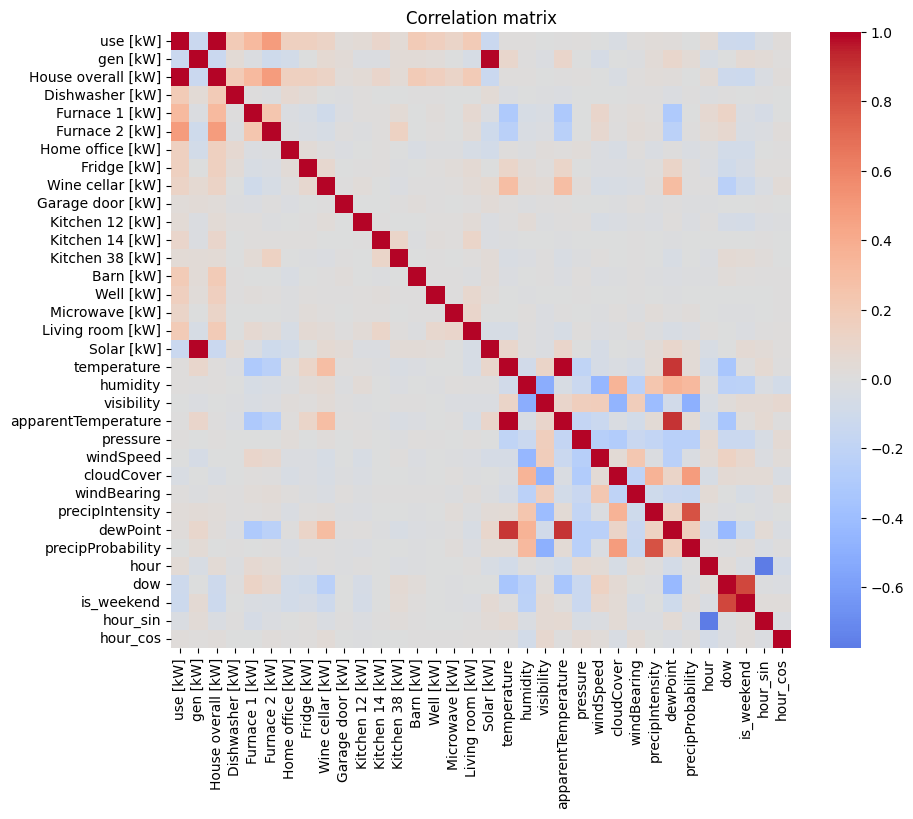

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

In [11]:
corr_cols = [
    "use [kW]",
    "gen [kW]",
    "Solar [kW]",
    "apparentTemperature",
    "dewPoint",
    "precipProbability",
]

df = df.drop(columns=corr_cols)

---

# Random Forest Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target = "House overall [kW]" 

features = [
    "hour_sin", "hour_cos", "is_weekend",
    "temperature", "humidity", "pressure",
    "windSpeed", "cloudCover",
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [13]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RF - RMSE: {rmse:.3f}")
print(f"RF - MAE : {mae:.3f}")
print(f"RF - R²  : {r2:.3f}")

RF - RMSE: 0.694
RF - MAE : 0.340
RF - R²  : 0.566


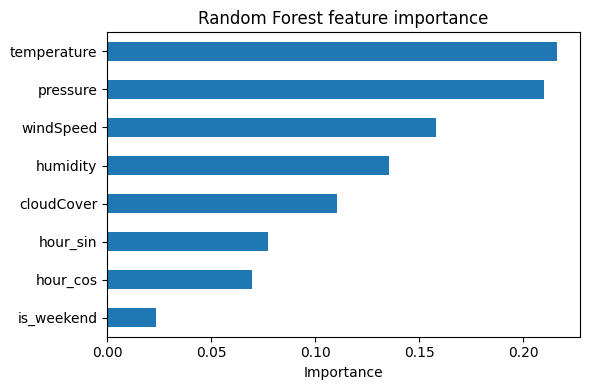

is_weekend     0.023439
hour_cos       0.069611
hour_sin       0.077183
cloudCover     0.110196
humidity       0.135427
windSpeed      0.157975
pressure       0.209781
temperature    0.216388
dtype: float64

In [14]:
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(6, 4))
fi.plot(kind="barh")
plt.title("Random Forest feature importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

fi

---

# Symbolic regression 

In [15]:
%%capture
from pysr import PySRRegressor 
import sympy as sp

X_sr = X_train[[
    "temperature", "pressure", "windSpeed",
    "humidity", "cloudCover",
    "hour_sin", "hour_cos", "is_weekend",
]]
y_sr = y_train

model_sr = PySRRegressor(
    niterations=100,              
    ncycles_per_iteration=100,  
    populations=10,             
    population_size=100,        
    batching=True,               
    batch_size=2048,            
    maxsize=15,                 
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "exp"],
    complexity_of_operators={"log": 2, "exp": 2},
    complexity_of_constants=1,
    complexity_of_variables=1,
    verbosity=0,
)

model_sr.fit(X_sr.values, y_sr.values)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ScientificTypesBase ────── v3.1.0
   Installed MicroMamba ─────────────── v0.1.14
   Installed Tricks ─────────────────── v0.1.13
   Installed MLJModelInterface ──────── v1.11.1
   Installed DynamicExpressions ─────── v1.10.3
   Installed Preferences ────────────── v1.5.1
   Installed JSON3 ──────────────────── v1.14.3
   Installed PythonCall ─────────────── v0.9.26
   Installed PositiveFactorizations ─── v0.2.4
   Installed ADTypes ────────────────── v1.21.0
   Installed StatisticalTraits ──────── v3.5.0
   Installed DynamicDiff ────────────── v0.2.1
   Installed SpecialFunctions ───────── v2.7.1
   Installed Optim ──────────────────── v1.13.3
   Installed ProgressMeter ──────────── v1.10.2
   Installed EnumX ──────────────────── v1.0.6
   Installed micromamba_jll ─────────── v1.5.12+0
   Installed FillArrays ─────────────── v1.16.0
   Installed ForwardDiff ────────────── v1.3.2
 

In [16]:
equations = model_sr.equations_
print(equations.columns)
equations.head()

Index(['complexity', 'loss', 'equation', 'score', 'sympy_format',
       'lambda_format'],
      dtype='object')


,complexity,loss,equation,score,sympy_format,lambda_format
0,1,1.122618,0.86012924,0.000000,0.860129240000000,PySRFunction(X=>0.860129240000000)
1,3,1.122526,x1 * 0.00084595976,0.000041,x1*0.00084595976,PySRFunction(X=>x1*0.00084595976)
2,5,1.107157,(x7 * -0.27824852) - -0.9528765,0.006893,x7*(-0.27824852) - 1*(-0.9528765),PySRFunction(X=>x7*(-0.27824852) - 1*(-0.95287...
3,7,1.104032,(x7 * (x0 * -0.00555698)) + 0.9581952,0.001413,x7*x0*(-0.00555698) + 0.9581952,PySRFunction(X=>x7*x0*(-0.00555698) + 0.9581952)
4,9,1.103611,((x7 * (x0 - x2)) * -0.0063914713) + 0.9466342,0.000191,x7*(x0 - x2)*(-0.0063914713) + 0.9466342,PySRFunction(X=>x7*(x0 - x2)*(-0.0063914713) +...


In [17]:
best_simple = equations.sort_values("complexity").iloc[0]     
best_medium = equations.sort_values("loss").iloc[0]          
best_complex = equations.sort_values("complexity").iloc[-1]   

candidates = {
    "simple": best_simple,
    "medium": best_medium,
    "complex": best_complex,
}

rows = []
for name, row in candidates.items():
    eq_idx = int(row.name)

    y_pred_train = model_sr.predict(X_sr.values, index=eq_idx)
    y_pred_test = model_sr.predict(X_test[X_sr.columns].values, index=eq_idx)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    rows.append([
        name,
        str(row["equation"]),
        row["complexity"],
        r2_train,
        r2_test,
    ])

results_sr = pd.DataFrame(
    rows,
    columns=["model", "formula", "complexity", "R2_train", "R2_test"],
)
results_sr

,model,formula,complexity,R2_train,R2_test
0,simple,0.86012924,1,-1.336992e-09,-0.000030
1,medium,exp(-0.00816381 * (((x7 * (x0 - x2)) - -0.7703...,15,1.711725e-02,0.017018
2,complex,exp(-0.00816381 * (((x7 * (x0 - x2)) - -0.7703...,15,1.711725e-02,0.017018
